# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=27ea22f2b8b53b8391089209d536ebf5dfff089c931445a86b7c41ca24d31b4c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=e64adc7d66bdc86b1a04fa7fa3c170c97e3dd92bad1b708463779b943692b97b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 18.48 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR= 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df= pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 2
row = df.iloc[idx]

image_path = f"{DATA_DIR}/{row.images}"
mask_path = f"{DATA_DIR}/{row.masks}"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

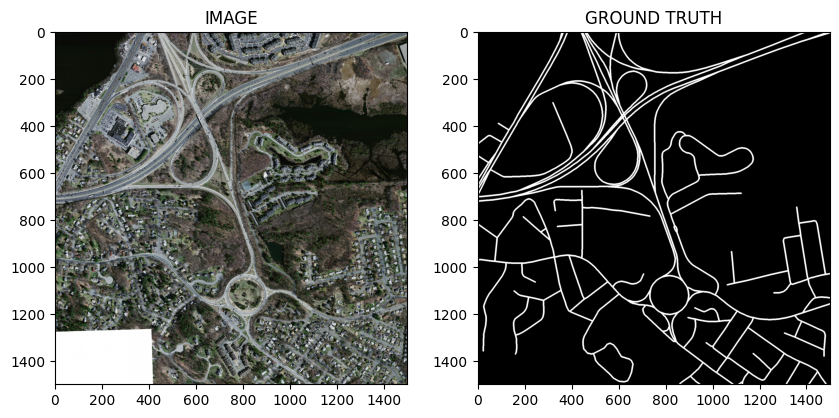

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentatinoDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = df.iloc[index]

    image_path = f"{DATA_DIR}/{row.images}"
    mask_path = f"{DATA_DIR}/{row.masks}"

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image =  data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentatinoDataset(train_df, get_train_augs())
validset = SegmentatinoDataset(valid_df, get_valid_augs())

In [ ]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')


Size of trainset : 159
Size of validset : 40


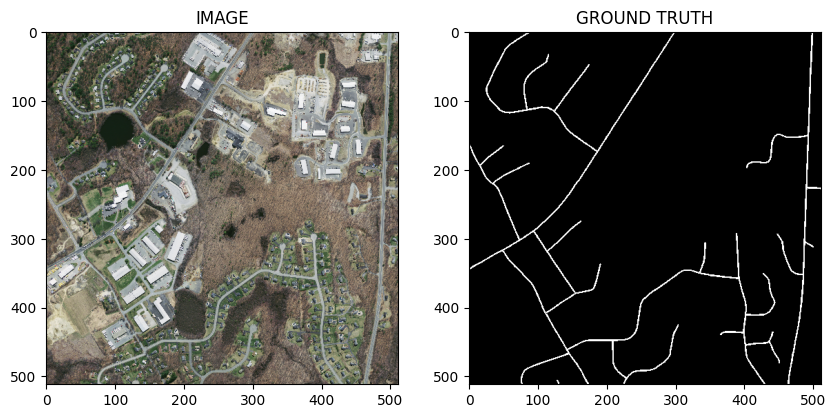

In [ ]:
idx = 69
image, mask = trainset[idx]

helper.show_image(image,mask)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"Total number of batched in trainlodaer : {len(trainloader)}")
print(f"Total number of batched in validlodaer : {len(validloader)}")

Total number of batched in trainlodaer : 20
Total number of batched in validlodaer : 5


In [ ]:
for images, masks in trainloader:
  print(f"One batch image shape : {images.shape}")
  print(f"One batch mask shape : {masks.shape}")
  break

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights= WEIGHTS,
        in_channels=3,
        classes = 1,
        activation=None
    )

  def forward(self, images, masks = None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

In [ ]:
def train_fn(dataloader, model, optimizer):

  model.train()

  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader, model):

  model.eval()

  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("SAVED-MODEL")
    best_loss = valid_loss

  print(f"Epoch : {i + 1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


SAVED-MODEL
Epoch : 1 Train Loss : 0.7891916036605835 Valid Loss : 0.7548522353172302


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


SAVED-MODEL
Epoch : 2 Train Loss : 0.7020468801259995 Valid Loss : 0.7168421745300293


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch : 3 Train Loss : 0.6995119750499725 Valid Loss : 0.8281789779663086


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


SAVED-MODEL
Epoch : 4 Train Loss : 0.6836281657218933 Valid Loss : 0.6966790080070495


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


SAVED-MODEL
Epoch : 5 Train Loss : 0.6727968484163285 Valid Loss : 0.6343320131301879


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


SAVED-MODEL
Epoch : 6 Train Loss : 0.6517000406980514 Valid Loss : 0.633914566040039


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch : 7 Train Loss : 0.6312307208776474 Valid Loss : 0.6656074523925781


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


SAVED-MODEL
Epoch : 8 Train Loss : 0.6324685841798783 Valid Loss : 0.621567165851593


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch : 9 Train Loss : 0.6341689348220825 Valid Loss : 0.6293501615524292


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


SAVED-MODEL
Epoch : 10 Train Loss : 0.6330735951662063 Valid Loss : 0.6186689138412476


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


SAVED-MODEL
Epoch : 11 Train Loss : 0.6297695010900497 Valid Loss : 0.5909180521965027


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch : 12 Train Loss : 0.6133712023496628 Valid Loss : 0.6001268982887268


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch : 13 Train Loss : 0.6106967180967331 Valid Loss : 0.6341706156730652


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


SAVED-MODEL
Epoch : 14 Train Loss : 0.5942255556583405 Valid Loss : 0.5883319973945618


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch : 15 Train Loss : 0.6053748399019241 Valid Loss : 0.6068066596984864


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epoch : 16 Train Loss : 0.5923563092947006 Valid Loss : 0.5810009002685547


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch : 17 Train Loss : 0.586147291958332 Valid Loss : 0.5822493851184845


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch : 18 Train Loss : 0.5823547393083572 Valid Loss : 0.6175244212150574


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch : 19 Train Loss : 0.5885241121053696 Valid Loss : 0.5990944743156433


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch : 20 Train Loss : 0.5855833545327187 Valid Loss : 0.5961531519889831


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


SAVED-MODEL
Epoch : 21 Train Loss : 0.5785055756568909 Valid Loss : 0.5453420758247376


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch : 22 Train Loss : 0.5726817592978477 Valid Loss : 0.556638878583908


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch : 23 Train Loss : 0.5666749253869057 Valid Loss : 0.548795759677887


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch : 24 Train Loss : 0.5641267687082291 Valid Loss : 0.5527164101600647


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

Epoch : 25 Train Loss : 0.5685863316059112 Valid Loss : 0.6284819006919861


In [ ]:
idx = 17

model.load_state_dict(torch.load("/content/best-model.pt"))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

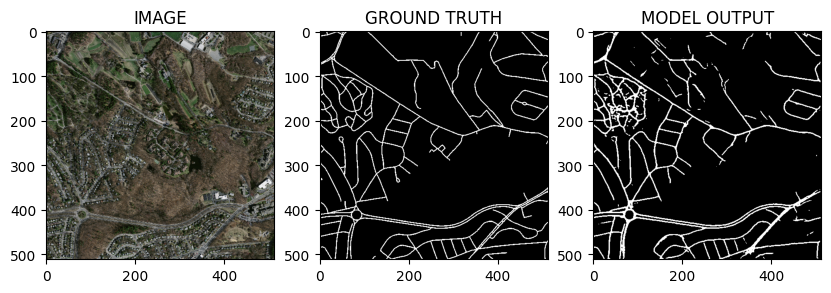

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))